# Fluctuation Analyses

This notebook covers 'fluctuation' analyses, which examine patterns of fluctuations in time series.

This notebook covers:
- The Hurst Exponent
- Detrended Fluctuation Analysis

In [1]:
from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined
from neurodsp.aperiodic import compute_fluctuations
from neurodsp.utils import set_random_seed
from neurodsp.aperiodic.conversions import convert_exponent_alpha

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_sims, run_sims_load
from apm.methods import hurst, dfa
from apm.methods.settings import HURST_PARAMS, DFA_PARAMS
from apm.plts.sims import plot_sims, plot_ap_sims, plot_pe_sims
from apm.plts.settings import EXT, COLORS
from apm.sim.settings import (N_SIMS, FS, EXP, EXPS, KNEES, FREQS, POWERS, BWS,
                              SIM_PARAMS_AP, SIM_PARAMS_COMB, SIM_PARAMS_KNEE)
from apm.sim.examples import SIG_AP, SIG_KN, SIG_OSC, SIG_COMB

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Set the random seed
set_random_seed(111)

In [5]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '22_fluctuations'

In [6]:
# Settings for loading simulations
SIMPATH = APMDB().sims_path / 'time_series'

## Hurst Exponent

The Hurst exponent is a method for measuring the self-similarity of a signal.

In [7]:
# Check Hurst exponent settings
HURST_PARAMS

{'fs': 250, 'n_scales': 10, 'min_scale': 0.1, 'max_scale': 2.0}

### Hurst Exponent on Example Signals

Compute the Hurst exponent on some example signals.

In [8]:
# Check the calculated hurst exponent, and the expected value
print('Computed Hurst signals:')
print('  powerlaw: \t {:1.4f} \t {:1.2f}'.format(hurst(SIG_AP, **HURST_PARAMS), 0.5))
print('  osc:      \t {:6.4f}'.format(hurst(SIG_OSC, **HURST_PARAMS)))
print('  combined: \t {:1.4f}'.format(hurst(SIG_COMB, **HURST_PARAMS)))
print('  knee:     \t {:1.4f}'.format(hurst(SIG_KN, **HURST_PARAMS)))

Computed Hurst signals:
  powerlaw: 	 0.6327 	 0.50
  osc:      	 -0.0033
  combined: 	 0.4561
  knee:     	 0.5712


### Hurst Exponent: Aperiodic Variations

In [9]:
# Run simulations calculating Hurst across exponents
hurst_sims_exp, hurst_sims_exp_var = run_sims(\
    sim_powerlaw, SIM_PARAMS_AP, hurst, HURST_PARAMS, 'update_exp', EXPS, N_SIMS)

In [10]:
# Run simulations calculating Hurst across exponents, with an oscillation
hurst_sims_comb, hurst_sims_comb_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, hurst, HURST_PARAMS, 'update_comb_exp', EXPS, N_SIMS)

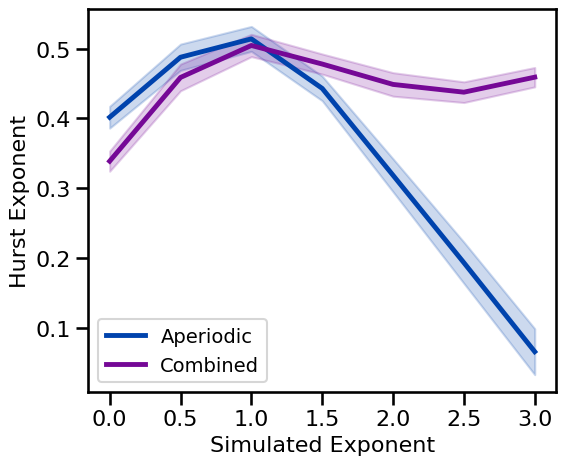

In [11]:
# Plot Hurst exponent estimates across aperiodic variations
plot_ap_sims(hurst_sims_exp, hurst_sims_exp_var, hurst_sims_comb, hurst_sims_comb_var,
             'Hurst Exponent', save_fig=SAVE_FIG, file_name='hurst_ap' + EXT, file_path=FIGPATH)

### Hurst Exponent: Periodic Variations

In [12]:
# Run simulations calculating Hurst Exponent across oscillation frequencies
hurst_sims_freq, hurst_sims_freq_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, hurst, HURST_PARAMS, 'update_freq', FREQS, N_SIMS)

In [13]:
# Run simulations calculating Hurst Exponent across oscillation power
hurst_sims_pow, hurst_sims_pow_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, hurst, HURST_PARAMS, 'update_pow', POWERS, N_SIMS)

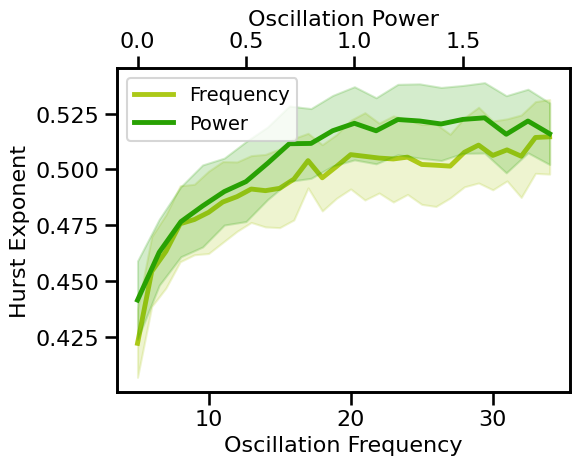

In [14]:
# Plot Hurst exponent estimates across periodic variations
plot_pe_sims(hurst_sims_freq, hurst_sims_freq_var, hurst_sims_pow, hurst_sims_pow_var,
             'Hurst Exponent', save_fig=SAVE_FIG, file_name='hurst_pe' + EXT, file_path=FIGPATH)

### Hurst Exponent: Knee Variations

In [15]:
# Run simulations calculating Hurst Exponent across different timescales
hurst_sims_knee, hurst_sims_knee_var = run_sims(\
    sim_synaptic_current, SIM_PARAMS_KNEE, hurst, HURST_PARAMS, 'update_knee', KNEES, N_SIMS)

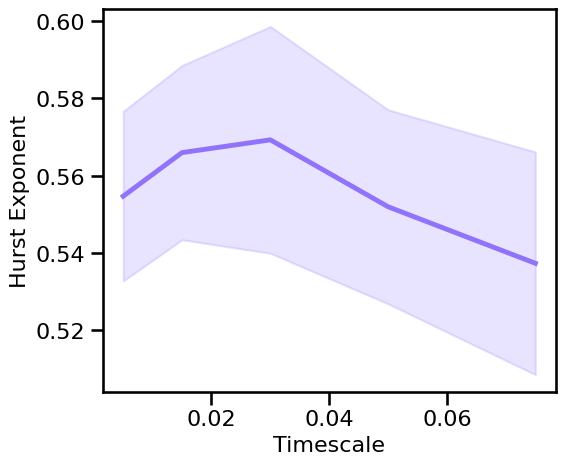

In [16]:
# Plot the estimated hurst exponent across different timescales
plot_sims(KNEES, hurst_sims_knee, hurst_sims_knee_var,
          'Timescale', 'Hurst Exponent', COLORS['KN'],
          save_fig=SAVE_FIG, file_name='hurst_knee' + EXT, file_path=FIGPATH)

### Hurst Exponent: Peak Variations

In [17]:
# Run simulations calculating Hurst Exponent across peak bandwidth (sims from file)
hurst_sims_bw, hurst_sims_bw_var = run_sims_load(\
    SIMPATH / 'ts_sims_comb_bw', hurst, HURST_PARAMS)

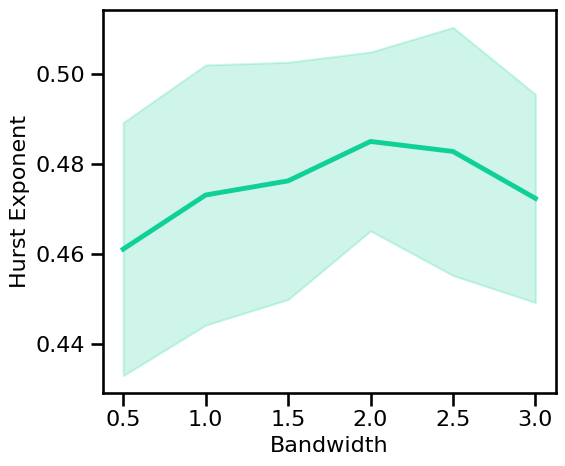

In [18]:
# Plot the estimated hurst exponent across peak bandwidth
plot_sims(BWS, hurst_sims_bw, hurst_sims_bw_var,
          'Bandwidth', 'Hurst Exponent', COLORS['BW'],
          save_fig=SAVE_FIG, file_name='hurst_bw' + EXT, file_path=FIGPATH)

## Detrended Fluctuation Analysis

Detrended Fluctuation Analysis is a method for measuring the self-similarity of a signal, and can be applied to measure properties of 1/f-distributed signals.

DFA measures an output value, $\alpha$ which can be interpreted as:
- $\alpha$ < 0.5   anti-correlated signal
- $\alpha$ ~= 0.5: uncorrelated / white noise
- $\alpha$ > 0.5: correlated
    - For example: pink noise ($1/f^1$) ~= 1 & brown noise ($1/f^2$) ~= 1.5

The DFA measure $\alpha$, _should_ relate to the power spectrum exponent $f^\chi$ as:
- $\chi$ = 2$\alpha$ - 1 or
- $\alpha$ = ($\chi$ + 1) / 2

### Settings

In [19]:
# Check DFA settings
DFA_PARAMS

{'fs': 250, 'n_scales': 10, 'min_scale': 0.1, 'max_scale': 2.0, 'deg': 1}

### DFA on Example Signals

In [20]:
# Check the computed DFA exponents on some example signals
print('DFA exponents:')
print('  powerlaw: \t {:1.4f} \t {:1.2f}'.format(dfa(SIG_AP, **DFA_PARAMS),
                                                 convert_exponent_alpha(EXP)))
print('  osc:      \t {:1.4f}'.format(dfa(SIG_OSC, **DFA_PARAMS)))
print('  combined: \t {:1.4f}'.format(dfa(SIG_COMB, **DFA_PARAMS)))
print('  knee:     \t {:1.4f}'.format(dfa(SIG_KN, **DFA_PARAMS)))

DFA exponents:
  powerlaw: 	 1.2092 	 1.25
  osc:      	 0.0078
  combined: 	 0.8800
  knee:     	 0.6201


### DFA Simulations: Aperiodic Variations

In [21]:
# Calculate the expected DFA exponent value for each powerlaw exponent
expected_dfa = [convert_exponent_alpha(exp) for exp in EXPS]

In [22]:
# Run simulations calculating DFA across exponents
dfa_sims_exp, dfa_sims_exp_var = run_sims(\
    sim_powerlaw, SIM_PARAMS_AP, dfa, DFA_PARAMS, 'update_exp', EXPS, N_SIMS)

In [23]:
# Run simulations calculating DFA across exponents, with an oscillation
dfa_sims_comb, dfa_sims_comb_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, dfa, DFA_PARAMS, 'update_comb_exp', EXPS, N_SIMS)

#### Plot Aperiodic & Combined Together

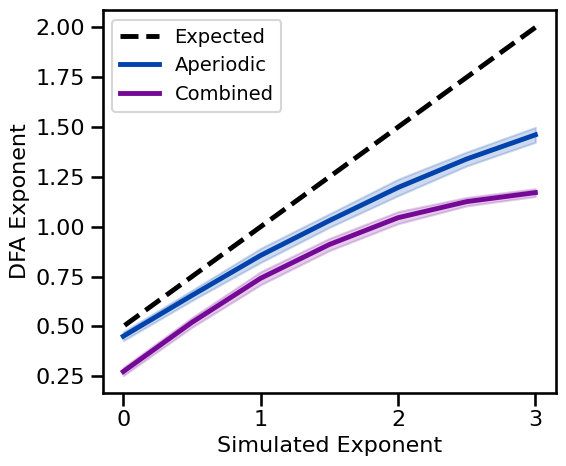

In [24]:
# Plot DFA measures across exponents
plot_ap_sims(dfa_sims_exp, dfa_sims_exp_var, dfa_sims_comb, dfa_sims_comb_var,
             'DFA Exponent', expected=expected_dfa,
             save_fig=SAVE_FIG, file_name='dfa_ap' + EXT, file_path=FIGPATH)

### DFA Simulations: Periodic Variations

In [25]:
# Run simulations calculating DFA across oscillation frequencies
dfa_sims_freq, dfa_sims_freq_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, dfa, DFA_PARAMS, 'update_freq', FREQS, N_SIMS)

In [26]:
# Run simulations calculating DFA across oscillation power
dfa_sims_pow, dfa_sims_pow_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, dfa, DFA_PARAMS, 'update_pow', POWERS, N_SIMS)

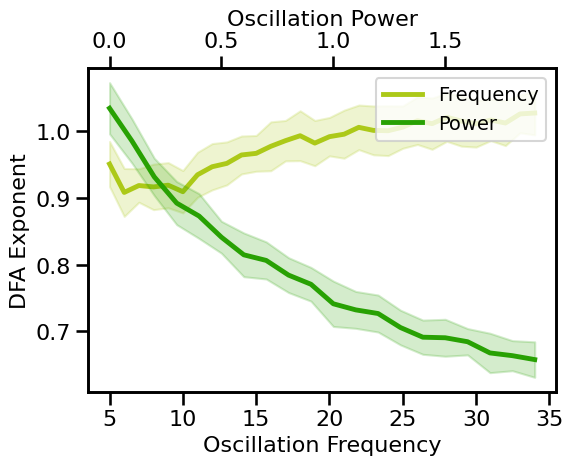

In [27]:
# Plot effect of oscillation variation on DFA exponent
plot_pe_sims(dfa_sims_freq, dfa_sims_freq_var, dfa_sims_pow, dfa_sims_pow_var,
             'DFA Exponent', save_fig=SAVE_FIG, file_name='dfa_pe' + EXT, file_path=FIGPATH)

### DFA Simulations: Knee Variations

In [28]:
# Run simulations calculating DFA Exponent across different timescales
dfa_sims_knee, dfa_sims_knee_var = run_sims(\
    sim_synaptic_current, SIM_PARAMS_KNEE, dfa, DFA_PARAMS, 'update_knee', KNEES, N_SIMS)

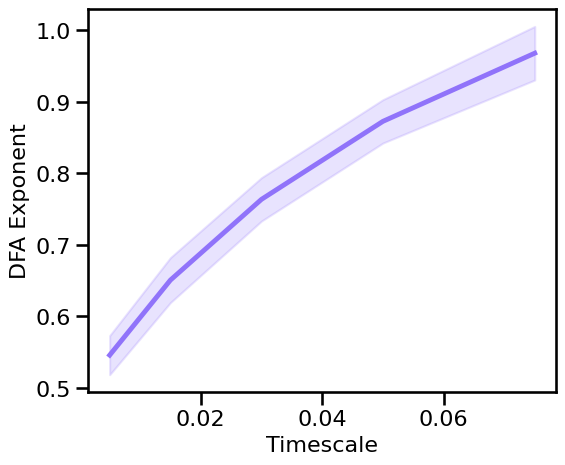

In [29]:
# Plot the estimated DFA exponent across different timescales
plot_sims(KNEES, dfa_sims_knee, dfa_sims_knee_var,
          'Timescale', 'DFA Exponent', COLORS['KN'],
          save_fig=SAVE_FIG, file_name='dfa_knee' + EXT, file_path=FIGPATH)

### DFA Simulations: Peak Variations

In [30]:
# Run simulations calculating DFA Exponent across peak bandwidth (sims from file)
dfa_sims_bw, dfa_sims_bw_var = run_sims_load(\
    SIMPATH / 'ts_sims_comb_bw', dfa, DFA_PARAMS)

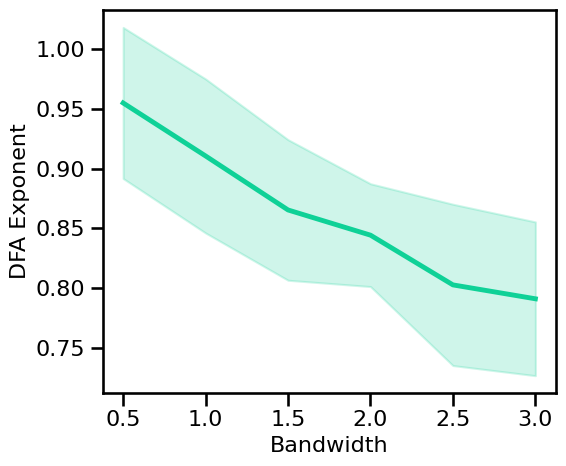

In [31]:
# Plot the estimated DFA exponent across peak bandwidth
plot_sims(BWS, dfa_sims_bw, dfa_sims_bw_var,
          'Bandwidth', 'DFA Exponent', COLORS['BW'],
          save_fig=SAVE_FIG, file_name='dfa_bw' + EXT, file_path=FIGPATH)

## Conclusions

Overall, we can see the following patterns in these simulations:

Hurst Exponent:
- has a parabolic relationship with aperiodic exponent, maximal at an exponent of -1
- is less affected by oscillation, increasing slightly with increasing frequency or power

Detrended Fluctuation Analysis:
- the estimated DFA increases with increasing aperiodic exponent 
    - the expected DFA results is well estimated across a range $\chi$ from ~ 0 to 2
    - the empirical DFA becomes less close the expected for increasing exponent values
- when an oscillation is present, the expected DFA value (for the 1/f) is decreases (is under-estimated)
- there is a complex relationship between estimated DFA and oscillation frequency
- estimated DFA decreases with increasing oscillation power